In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')





In [ ]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]

    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

print(df_train.shape)

<ipython-input-11-68009c438c6b>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


(22941656, 6)


In [ ]:
# Loads first 5 rows
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,NaN
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN


In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,3980341


In [ ]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-14-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [ ]:
df_stores.isnull().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [ ]:
df_holidays_events.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [ ]:
df_items.isnull().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


In [ ]:
df_oil.isnull().sum()
m = df_oil['dcoilwtico'].mean()


In [ ]:
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [ ]:

df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(m)
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


In [ ]:
df_transactions.isnull().sum()

,0
date,0
store_nbr,0
transactions,0


In [ ]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
87113,507901,2013-01-14,30,959437,-34.0,False
93833,547212,2013-01-15,30,812751,-168.0,False


In [ ]:
# Initialize a list to collect outlier rows
outliers_list = []

# Iterate over each store-item group
for (store, item), group in df_train.groupby(['store_nbr', 'item_nbr']):
    # Compute mean and standard deviation
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Handle division by zero (if std is 0)
    if std_sales == 0:
        std_sales = 1  # Avoids division by zero, z-scores become (x - mean)

    # Calculate Z-scores for this group
    z_scores = (group['unit_sales'] - mean_sales) / std_sales

    # Identify outliers in this group
    mask_outliers = z_scores > 5
    group_outliers = group.loc[mask_outliers]

    # Collect outliers if any exist
    if not group_outliers.empty:
        outliers_list.append(group_outliers)

# Combine all outliers into a single DataFrame
outliers = pd.concat(outliers_list, ignore_index=True) if outliers_list else pd.DataFrame()

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
if not outliers.empty:
    print(outliers.head())
else:
    print("No outliers found.")

Number of outliers detected: 66817
         id        date  store_nbr  item_nbr  unit_sales  onpromotion
0  15666702  2013-12-18         24     96995        14.0        False
1  59775862  2015-10-20         24     99197        14.0        False
2  60322807  2015-10-26         24     99197        19.0        False
3  15717753  2013-12-19         24    103520        27.0        False
4  18886543  2014-02-13         24    103520        22.0        False


In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get min/max date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Define output file path
output_file = "/content/drive/My Drive/df_filled.csv"
chunk_size = 1000  # Adjust based on memory availability

# Create an empty CSV with headers
columns = ["date", "store_nbr", "item_nbr", "unit_sales", "onpromotion"]
pd.DataFrame(columns=columns).to_csv(output_file, index=False)

# Process in chunks and append to disk
for (store, item), group in df_train.groupby(['store_nbr', 'item_nbr']):
    # Reindex while keeping 'date' as a column
    group = group.set_index('date').reindex(full_date_range, fill_value=0).reset_index()
    group.rename(columns={'index': 'date'}, inplace=True)  # Ensure 'date' column exists

    # Ensure the date column is in the correct format
    group['date'] = pd.to_datetime(group['date'])  # Convert again to ensure correct format

    # Fill missing values and set columns correctly
    group['onpromotion'] = group['onpromotion'].fillna(False).astype(bool)
    group['store_nbr'] = store
    group['item_nbr'] = item
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append to CSV in chunks
    group.to_csv(output_file, mode='a', header=False, index=False, chunksize=chunk_size)

print(f"Processed data saved to {output_file}")


Processed data saved to /content/drive/My Drive/df_filled.csv


In [ ]:
df_filled = pd.read_csv('/content/drive/My Drive/df_filled.csv')


In [ ]:
print(df_filled.head(20))

              date  store_nbr  item_nbr  unit_sales  onpromotion
2013-01-02       0         24     96995         0.0        False
2013-01-03       0         24     96995         0.0        False
2013-01-04       0         24     96995         0.0        False
2013-01-05       0         24     96995         0.0        False
2013-01-06       0         24     96995         0.0        False
2013-01-07       0         24     96995         0.0        False
2013-01-08       0         24     96995         0.0        False
2013-01-09  302230         24     96995         2.0        False
2013-01-10       0         24     96995         0.0        False
2013-01-11       0         24     96995         0.0        False
2013-01-12  419989         24     96995         2.0        False
2013-01-13       0         24     96995         0.0        False
2013-01-14       0         24     96995         0.0        False
2013-01-15       0         24     96995         0.0        False
2013-01-16  582436       

In [ ]:
df_filled = pd.read_csv(output_file, index_col=0)  # Read CSV, treating first column as index
df_filled.drop(columns=['date'], inplace=True)
df_filled.reset_index(inplace=True)  # Convert index to a column
df_filled.rename(columns={'index': 'date'}, inplace=True)  # Rename column

In [ ]:
df_filled.head (20)

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-02,24,96995,0.0,False
1,2013-01-03,24,96995,0.0,False
2,2013-01-04,24,96995,0.0,False
3,2013-01-05,24,96995,0.0,False
4,2013-01-06,24,96995,0.0,False
5,2013-01-07,24,96995,0.0,False
6,2013-01-08,24,96995,0.0,False
7,2013-01-09,24,96995,2.0,False
8,2013-01-10,24,96995,0.0,False
9,2013-01-11,24,96995,0.0,False


In [ ]:
output_fixed_file = "/content/drive/My Drive/df_filled_fixed.csv"

df_filled.to_csv(output_fixed_file, index=False)  # Save without the index

print(f"Fixed data saved to {output_fixed_file}")


Fixed data saved to /content/drive/My Drive/df_filled_fixed.csv


In [ ]:
df_filled.shape

(58510221, 5)

In [ ]:
df_filled.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-02,24,96995,0.0,False
1,2013-01-03,24,96995,0.0,False
2,2013-01-04,24,96995,0.0,False
3,2013-01-05,24,96995,0.0,False
4,2013-01-06,24,96995,0.0,False


In [ ]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,False
1,18790,2013-01-02,24,105574,12.0,False
2,18791,2013-01-02,24,105575,2.0,False
3,18792,2013-01-02,24,105577,1.0,False
4,18793,2013-01-02,24,105693,7.0,False


In [ ]:
'''import shutil

# Define the destination path in Google Drive
drive_path = '/content/drive/My Drive/df_filled.csv'

# Copy the file from local Colab storage to Google Drive
shutil.copy('/content/df_filled.csv', drive_path)

print(f"File saved to Google Drive: {drive_path}")'''

File saved to Google Drive: /content/drive/My Drive/df_filled.csv


In [ ]:
# Define the date range
start_date = '2014-01-01'
end_date = '2014-03-31'

# Ensure 'date' is in datetime format
df_filled['date'] = pd.to_datetime(df_filled['date'])

# Apply the date filter
df_filtered = df_filled[(df_filled['date'] >= start_date) & (df_filled['date'] <= end_date)]

# Define the new output file path
output_filtered_file = "/content/drive/My Drive/df_filled_filtered.csv"

# Save the filtered DataFrame to CSV
df_filtered.to_csv(output_filtered_file, index=False)  # Save without index

print(f"Filtered data saved to {output_filtered_file}")


Filtered data saved to /content/drive/My Drive/df_filled_filtered.csv


In [ ]:
# Define paths (point to your Google Drive)
input_file = "/content/drive/My Drive/df_filled_fixed.csv"  # Path to the filled dataset on Google Drive
output_file = "/content/drive/My Drive/df_filled_with_features.csv"  # Path to save the processed data on Google Drive

# Define chunk size
chunk_size = 100000  # Adjust based on your system's memory capacity

# Create an empty CSV with headers
columns = ["date", "store_nbr", "item_nbr", "unit_sales", "onpromotion", "year", "month", "day", "day_of_week", "unit_sales_7d_avg"]
pd.DataFrame(columns=columns).to_csv(output_file, index=False)

# Process data in chunks
for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    # Convert 'date' column to datetime format
    chunk['date'] = pd.to_datetime(chunk['date'])

    # Create time-based features
    chunk['year'] = chunk['date'].dt.year
    chunk['month'] = chunk['date'].dt.month
    chunk['day'] = chunk['date'].dt.day
    chunk['day_of_week'] = chunk['date'].dt.dayofweek  # Monday=0, Sunday=6

    # Calculate rolling average of unit_sales
    chunk['unit_sales_7d_avg'] = chunk.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # Append the processed chunk to the output file
    chunk.to_csv(output_file, mode='a', header=False, index=False)

print(f"Processed data saved to Google Drive: {output_file}")

Processed data saved to Google Drive: /content/drive/My Drive/df_filled_with_features.csv


In [ ]:
# Define paths (point to your Google Drive)
input_file1 = "/content/drive/My Drive/df_filled_filtered.csv"  # Path to the filled dataset on Google Drive
output_file1 = "/content/drive/My Drive/df_filled_with_features_filtered.csv"  # Path to save the processed data on Google Drive

# Define chunk size
chunk_size = 1000  # Adjust based on your system's memory capacity

# Create an empty CSV with headers
columns = ["date", "store_nbr", "item_nbr", "unit_sales", "onpromotion", "year", "month", "day", "day_of_week", "unit_sales_7d_avg"]
pd.DataFrame(columns=columns).to_csv(output_file1, index=False)

# Process data in chunks
for chunk in pd.read_csv(input_file1, chunksize=chunk_size):
    # Convert 'date' column to datetime format
    chunk['date'] = pd.to_datetime(chunk['date'])

    # Create time-based features
    chunk['year'] = chunk['date'].dt.year
    chunk['month'] = chunk['date'].dt.month
    chunk['day'] = chunk['date'].dt.day
    chunk['day_of_week'] = chunk['date'].dt.dayofweek  # Monday=0, Sunday=6

    # Calculate rolling average of unit_sales
    chunk['unit_sales_7d_avg'] = chunk.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # Append the processed chunk to the output file
    chunk.to_csv(output_file1, mode='a', header=False, index=False)

print(f"Processed data saved to Google Drive: {output_file1}")

Processed data saved to Google Drive: /content/drive/My Drive/df_filled_with_features_filtered.csv


In [ ]:
test_df_features = pd.read_csv('/content/drive/My Drive/df_filled_with_features.csv', nrows = 10)
print(test_df_features)

         date  store_nbr  item_nbr  unit_sales  onpromotion  year  month  day  \
0  2013-01-02         24     96995         0.0        False  2013      1    2   
1  2013-01-03         24     96995         0.0        False  2013      1    3   
2  2013-01-04         24     96995         0.0        False  2013      1    4   
3  2013-01-05         24     96995         0.0        False  2013      1    5   
4  2013-01-06         24     96995         0.0        False  2013      1    6   
5  2013-01-07         24     96995         0.0        False  2013      1    7   
6  2013-01-08         24     96995         0.0        False  2013      1    8   
7  2013-01-09         24     96995         2.0        False  2013      1    9   
8  2013-01-10         24     96995         0.0        False  2013      1   10   
9  2013-01-11         24     96995         0.0        False  2013      1   11   

   day_of_week  unit_sales_7d_avg  
0            2           0.000000  
1            3           0.000000  


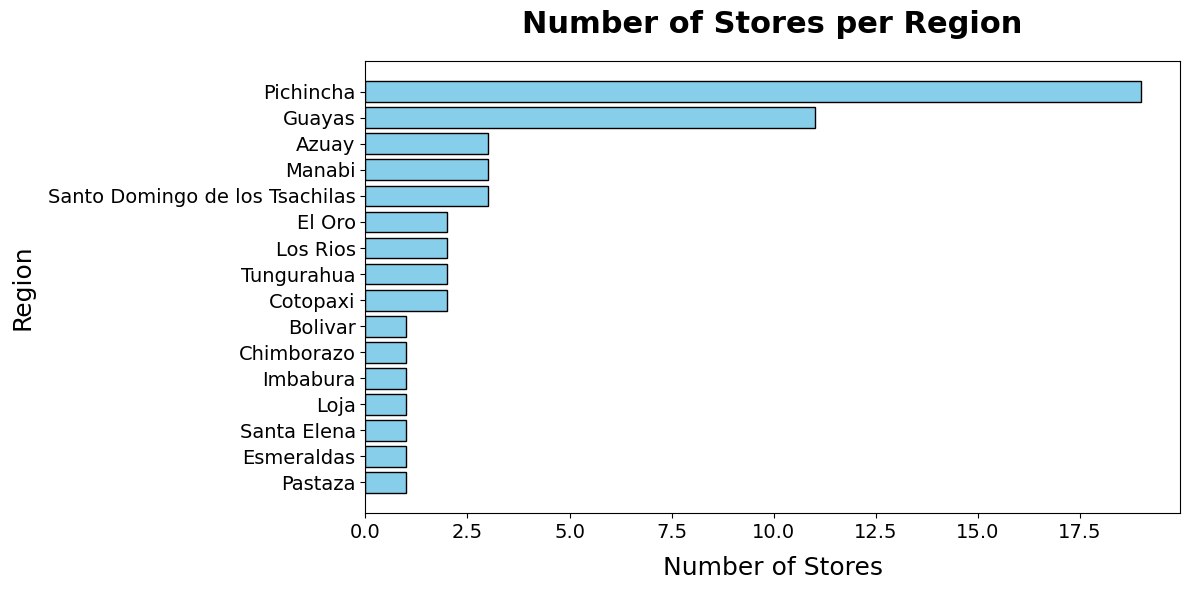

In [ ]:
# Plotting the number of stores per region (state)
# Count the number of stores per region and sort in ascending order
stores_per_region = df_stores['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

# Plot the sorted data
plt.figure(figsize=(12, 6))  # Increase figure size for better readability
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')  # Use horizontal bar plot
# Titles and labels with enhanced formatting
plt.title("Number of Stores per Region", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=18, labelpad=10)
plt.ylabel("Region", fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
# Convert 'date' column to datetime (if not already done)
df_filled['date'] = pd.to_datetime(df_filled['date'])

# Check the time range
min_date = df_filled['date'].min()
max_date = df_filled['date'].max()

print(f"Time range of the dataset: From {min_date} to {max_date}")

Time range of the dataset: From 2013-01-02 00:00:00 to 2017-08-15 00:00:00


In [ ]:
# Count the number of unique stores in the Guayas region
num_stores_guayas = df_filled['store_nbr'].nunique()
print(f"Number of stores in Guayas: {num_stores_guayas}")

Number of stores in Guayas: 11


In [ ]:
# Calculate the average number of unique products sold per store
avg_products_per_store = df_filled.groupby('store_nbr')['item_nbr'].nunique().mean()
print(f"Average number of products sold per store: {avg_products_per_store:.2f}")

Average number of products sold per store: 3153.00


In [ ]:
# Calculate the number of unique products sold per store
products_per_store = df_filled.groupby('store_nbr')['item_nbr'].nunique().reset_index()
products_per_store.columns = ['store_nbr', 'avg_products_sold']

# Display the result
print(products_per_store)

    store_nbr  avg_products_sold
0          24               3597
1          26               3448
2          27               3599
3          28               3133
4          29               3098
5          30               2655
6          32               2556
7          34               3138
8          35               2617
9          36               3196
10         51               3646


<ipython-input-41-91c44c3cc25e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='store_nbr', y='avg_products_sold', data=products_per_store, palette='viridis')


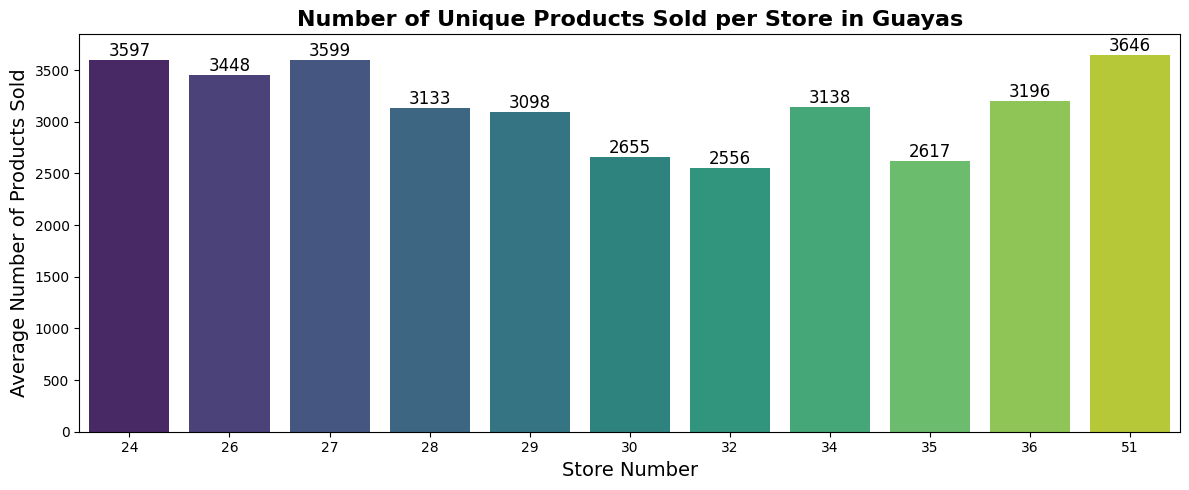

In [ ]:

# Set up the plot
plt.figure(figsize=(12, 5))

# Create the bar plot
sns.barplot(x='store_nbr', y='avg_products_sold', data=products_per_store, palette='viridis')

# Add title and labels
plt.title("Number of Unique Products Sold per Store in Guayas", fontsize=16, fontweight='bold')
plt.xlabel("Store Number", fontsize=14)
plt.ylabel("Average Number of Products Sold", fontsize=14)

# Add value labels on top of the bars
for index, row in products_per_store.iterrows():
    plt.text(index, row['avg_products_sold'] + 1, f"{row['avg_products_sold']:.0f}", ha='center', va='bottom', fontsize=12)

# Adjust y-axis limit for better visualization
plt.ylim(0, products_per_store['avg_products_sold'].max() + 200)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the average total quantity of products sold per store
avg_total_products = df_filled.groupby('store_nbr')['unit_sales'].sum().mean()
print(f"Average total quantity of products sold per store: {avg_total_products:.2f}")

Average total quantity of products sold per store: 15015758.85


In [ ]:
# Calculate total quantity of products sold per store
total_products_per_store = df_filled.groupby('store_nbr')['unit_sales'].sum().reset_index()
total_products_per_store.columns = ['store_nbr', 'total_products_sold']

# Display the result
print(total_products_per_store)

    store_nbr  total_products_sold
0          24         2.376835e+07
1          26         7.755795e+06
2          27         1.918919e+07
3          28         1.838425e+07
4          29         9.726442e+06
5          30         7.382537e+06
6          32         5.962198e+06
7          34         1.709112e+07
8          35         7.676878e+06
9          36         1.532403e+07
10         51         3.291256e+07


<ipython-input-44-47300c7090e0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='store_nbr', y='total_products_sold', data=total_products_per_store, palette='viridis')


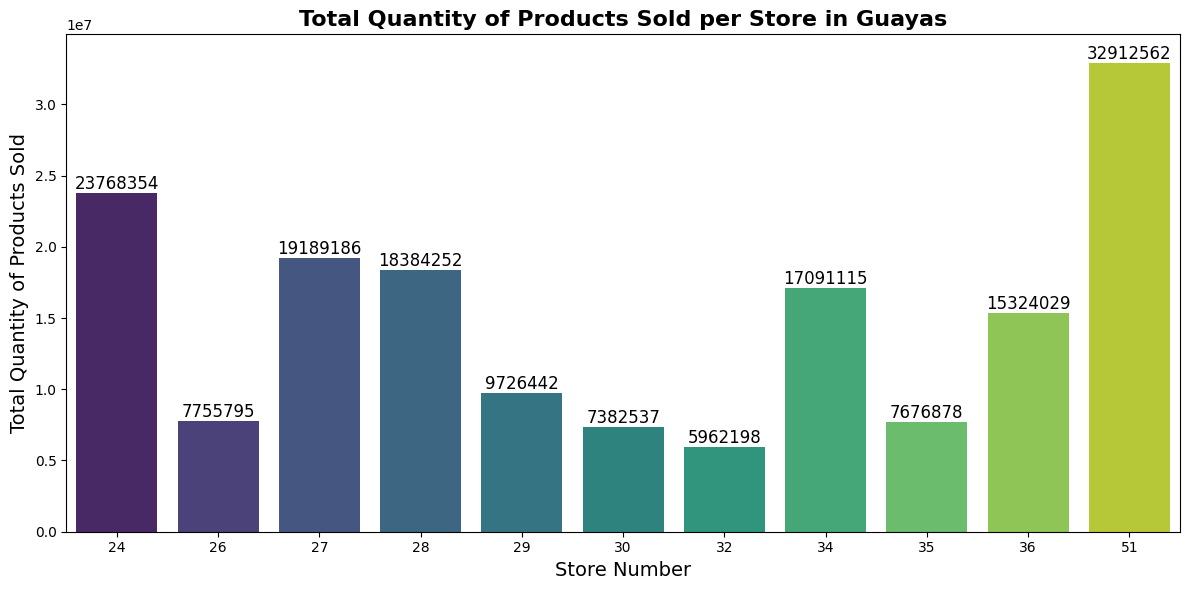

In [ ]:


# Set up the plot
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(x='store_nbr', y='total_products_sold', data=total_products_per_store, palette='viridis')

# Add title and labels
plt.title("Total Quantity of Products Sold per Store in Guayas", fontsize=16, fontweight='bold')
plt.xlabel("Store Number", fontsize=14)
plt.ylabel("Total Quantity of Products Sold", fontsize=14)

# Add value labels on top of the bars
for index, row in total_products_per_store.iterrows():
    plt.text(index, row['total_products_sold'] + 100, f"{row['total_products_sold']:.0f}", ha='center', va='bottom', fontsize=12)

# Adjust y-axis limit for better visualization
plt.ylim(0, total_products_per_store['total_products_sold'].max() + 2000000)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate total unit_sales per store
store_sales = df_filled.groupby('store_nbr')['unit_sales'].sum().reset_index()

# Sort stores by total unit_sales in descending order
largest_stores = store_sales.sort_values(by='unit_sales', ascending=False)

# Display the top 3 largest stores
print("Top 10 largest stores by total unit sales:")
print(largest_stores.head(3))

Top 10 largest stores by total unit sales:
    store_nbr    unit_sales
10         51  3.291256e+07
0          24  2.376835e+07
2          27  1.918919e+07


In [ ]:
# Merge df_filled with df_items to get the 'family' column
merged_data = pd.merge(df_filled, df_items, on='item_nbr', how='left')

# Calculate total unit_sales per family
family_sales = merged_data.groupby('family')['unit_sales'].sum().reset_index()

# Sort families by total unit_sales in descending order
top_families = family_sales.sort_values(by='unit_sales', ascending=False)

# Display the top 3 performing families
print("Top 3 performing product families:")
print(top_families.head(3))

Top 3 performing product families:
       family    unit_sales
12  GROCERY I  5.175540e+07
3   BEVERAGES  3.452960e+07
30    PRODUCE  1.875662e+07


In [ ]:
# Group by item_nbr and find the earliest date for each item
new_items = merged_data.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month from the date
new_items['year_month'] = new_items['date'].dt.to_period('M')

# Count the number of new items introduced per month
new_items_per_month = new_items.groupby('year_month').size().reset_index(name='new_item_count')

# Display the frequency of new items introduced
print("Number of new items introduced per month:")
print(new_items_per_month)

# Get details of the new items (family, class, etc.)
new_items_details = pd.merge(new_items, df_items, on='item_nbr', how='left')
print("Details of new items introduced:")
print(new_items_details.head())

Number of new items introduced per month:
  year_month  new_item_count
0    2013-01            4008
Details of new items introduced:
   item_nbr       date year_month        family  class  perishable
0     96995 2013-01-02    2013-01     GROCERY I   1093           0
1     99197 2013-01-02    2013-01     GROCERY I   1067           0
2    103501 2013-01-02    2013-01      CLEANING   3008           0
3    103520 2013-01-02    2013-01     GROCERY I   1028           0
4    103665 2013-01-02    2013-01  BREAD/BAKERY   2712           1


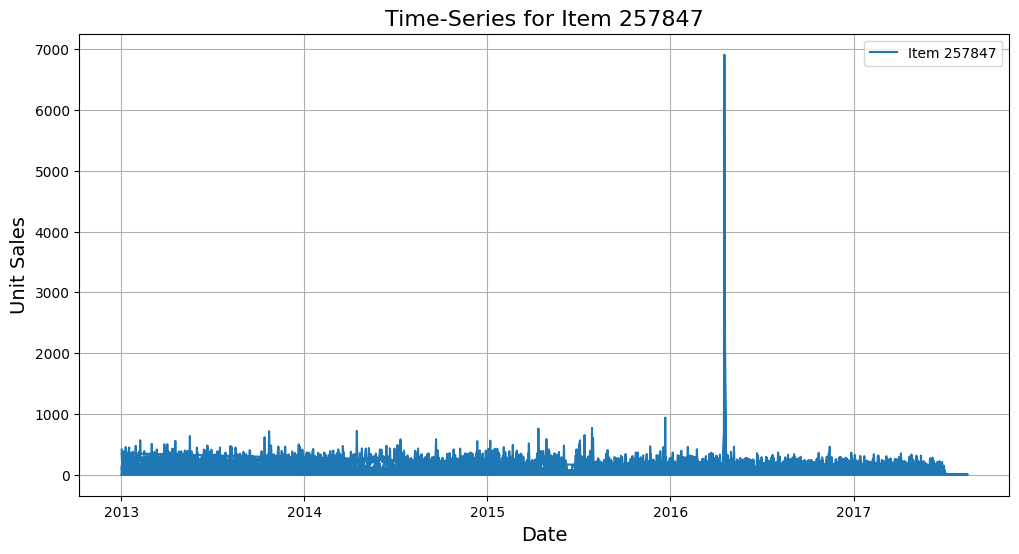

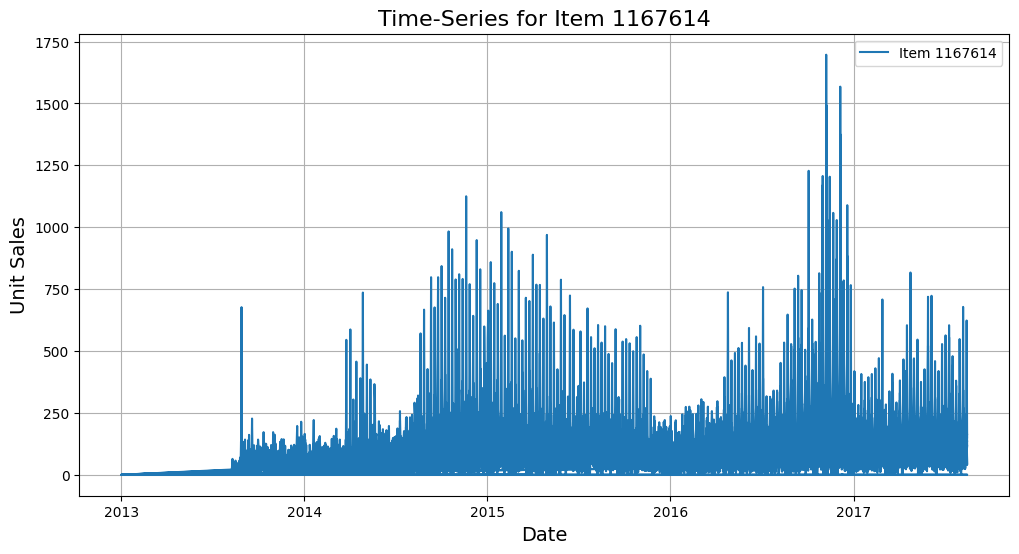

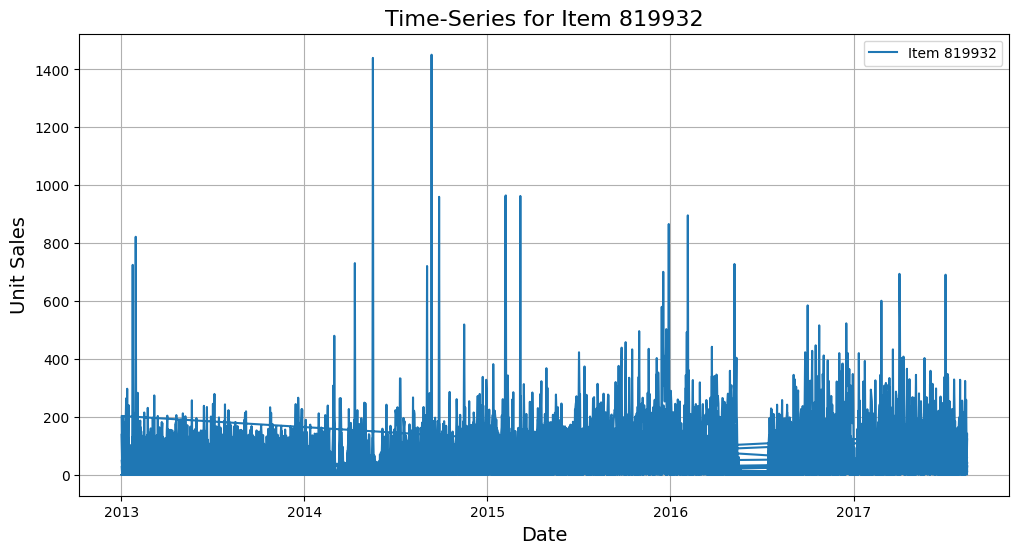

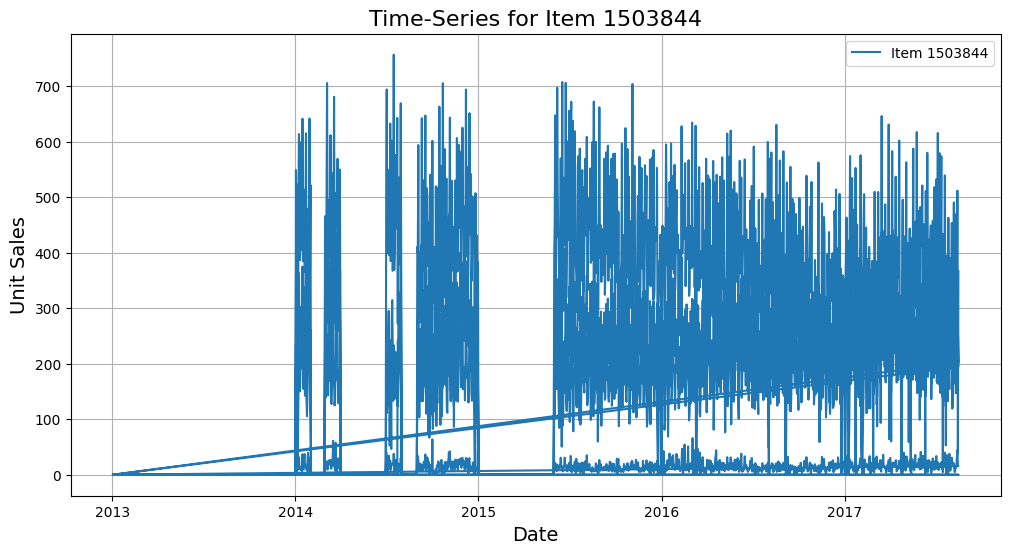

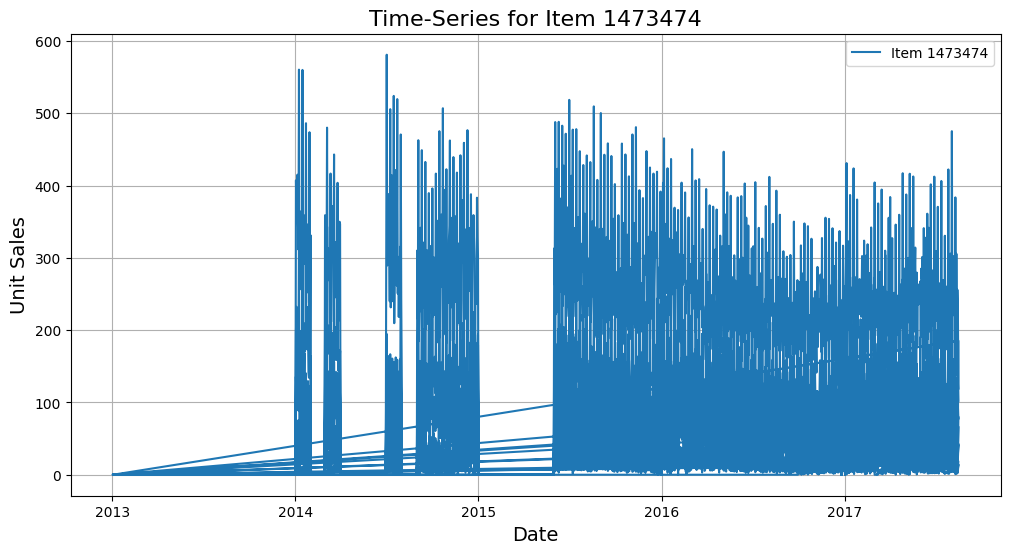

In [ ]:
# Identify top-selling items (e.g., top 5 items by total unit_sales)
top_items = merged_data.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(5).index

# Plot time-series for top-selling items
for item in top_items:
    item_data = merged_data[merged_data['item_nbr'] == item]
    plt.figure(figsize=(12, 6))
    plt.plot(item_data['date'], item_data['unit_sales'], label=f'Item {item}')
    plt.title(f"Time-Series for Item {item}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Unit Sales", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()